In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp  # https://pypi.org/project/scikit-posthocs/
import matplotlib.pyplot as plt
import os

import config
from evaluation.eegbci_time_intvls import load_eegbci_time_intvls_results

# Read results from both BCI datasets

Each subject is going to be considered as a separate dataset in the Friedman test.


In [4]:
BNCI2014_001_res = pd.read_csv(f"{config.DISK_PATH}/{os.getenv('BNCI2014_001_MAIN_RESULTS')}")
BNCI2014_001_res = BNCI2014_001_res[BNCI2014_001_res["session"] == "1test"].reset_index(drop=True)

eegbci_res = load_eegbci_time_intvls_results(f"{config.DISK_PATH}/{os.getenv('EEGBCI_TIME_INTVLS_MAIN_RESULTS')}")
eegbci_res = eegbci_res[
    eegbci_res["subject"] <= eegbci_res[eegbci_res["pipeline"] == "IntvlChoquetEnsemble"]["subject"].max()
]

In [5]:
models = BNCI2014_001_res.pipeline.unique()
results_df = pd.DataFrame(columns=models)

In [6]:
for subject in BNCI2014_001_res["subject"].unique():
    current_subj = BNCI2014_001_res[BNCI2014_001_res["subject"] == subject]

    results_df.loc[len(results_df.index)] = [
        current_subj[current_subj["pipeline"] == model]["score"].values[0] for model in models
    ]

In [8]:
for subject in eegbci_res["subject"].unique():
    current_subj = eegbci_res[eegbci_res["subject"] == subject]

    results_df.loc[len(results_df.index)] = [
        np.mean(current_subj[current_subj["pipeline"] == model]["scores"].values[0]) for model in models
    ]

In [11]:
results_df.head()

,IntvlChoquetEnsemble,CSP-LDA,IntvlChoquetEnsembleNBest,IntvlMeanEnsemble,IntvlSugenoEnsemble
0,0.973810,0.968231,0.974898,0.974898,0.967823
1,0.701497,0.535238,0.695782,0.696327,0.627449
2,0.994286,0.997143,0.994286,0.993333,0.975238
3,0.837959,0.866054,0.838027,0.844830,0.809320
4,0.731429,0.655170,0.736259,0.745850,0.692245


## Friedman testing

Non parametric test to check if there is a difference in means between the groups (classifiers)


In [13]:
alpha = 0.05  # Set this to the desired alpha/signifance level

stat, p = stats.friedmanchisquare(*np.asarray(results_df))

reject = p <= alpha
print(
    "Should we reject H0 (i.e. is there a difference in the means) at the",
    (1 - alpha) * 100,
    "% confidence level? ->",
    reject,
)

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? -> True


### Post Hoc Analysis

See [Statistical Comparisons of Classifiers over Multiple Data Sets](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.141.3142&rep=rep1&type=pdf) for more detail


In [14]:
# At this point, we should only continue if H0 was rejected
if not reject:
    raise Exception(
        "Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above"
    )

In [15]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args)  # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis="columns", inplace=True)  # Label the cols
    pairwise_scores.set_axis(
        labels, axis="rows", inplace=True
    )  # Label the rows, note: same label as pairwise combinations
    return pairwise_scores


def plot(scores):
    # Pretty plot of significance
    heatmap_args = {"linewidths": 0.25, "linecolor": "0.5", "square": True, "cbar_ax_bbox": [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

#### Nemenyi Test

Note: This is relevant when you would like to compare various methods.
For example if you propose several methods and want to compare them all against each
other, or to do an exhaustive comparison against several method. Often this is not
what we want, as we propose only one method (instead see Bonferoni below), and this would
be overconservativew.


In [16]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, np.asarray(results_df), results_df.columns)

C:\Users\villarmario\AppData\Local\Temp\ipykernel_15656\724679618.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis="columns", inplace=True)  # Label the cols
C:\Users\villarmario\AppData\Local\Temp\ipykernel_15656\724679618.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(


In [18]:
# Shows the p values for each pair
nemenyi_scores

,IntvlChoquetEnsemble,CSP-LDA,IntvlChoquetEnsembleNBest,IntvlMeanEnsemble,IntvlSugenoEnsemble
IntvlChoquetEnsemble,1.000000,0.900000,0.900000,0.900000,0.085509
CSP-LDA,0.900000,1.000000,0.900000,0.900000,0.025068
IntvlChoquetEnsembleNBest,0.900000,0.900000,1.000000,0.900000,0.111801
IntvlMeanEnsemble,0.900000,0.900000,0.900000,1.000000,0.151149
IntvlSugenoEnsemble,0.085509,0.025068,0.111801,0.151149,1.000000


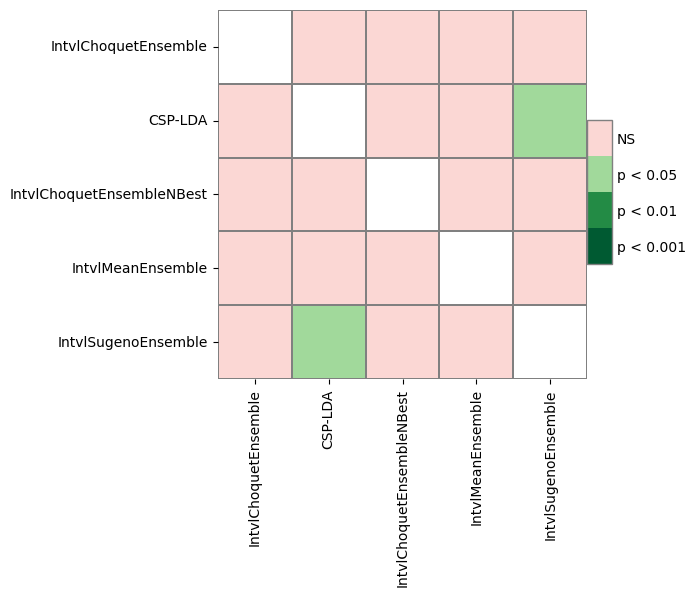

In [19]:
plot(nemenyi_scores)  # NS = non-significant differences